In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import seaborn as sns
%matplotlib inline

import pywt
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve

In [2]:
test_path = os.path.join('data','test.csv')
train_path = os.path.join('data','train.csv')

test_df = pd.read_csv(test_path)
train_df = pd.read_csv(train_path)

In [3]:
train_df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [4]:
test_df.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


Visualising the training dataset to see if we need to remove any anaomalies

[Text(0, 0.5, 'signal (pA)'),
 Text(0.5, 0, 'time (s)'),
 Text(0.5, 1.0, 'Signal(pA) over time(s)')]

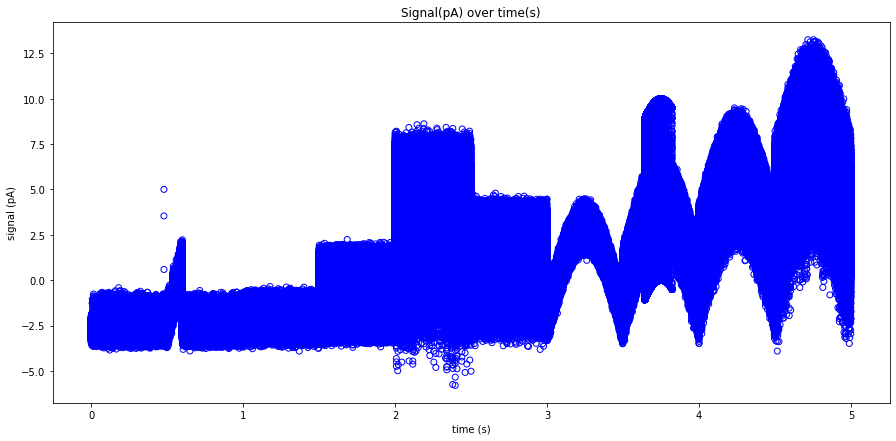

In [5]:
fig0, ax0 = plt.subplots(figsize=(15,7))

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
open_channels_train = train_df.open_channels

ax0.scatter(time_train, signal_train, color='none', edgecolor='blue', marker='o');
ax0.set(xlabel='time (s)', ylabel='signal (pA)',
        title='Signal(pA) over time(s)')

The first graph clearly shows that between 0 and 1.5 seconds show a signal range of -2.5 to 0 pA.  There could either be anomolies or the initiation of ion channels of up to 5 pA.  The signals start to show a consistant positive signal after 1.5 seconds, however, it shows a range of ~ -5 to 13 pA. After 3 seconds, there are almost 'leapfrongs' in the intensity of signals ranging from ~ -5 to 13 pA as said before.

[Text(0, 0.5, 'signal (pA)'),
 Text(0.5, 0, 'Number of open Channels'),
 Text(0.5, 1.0, 'Signal and Number of Open Channels')]

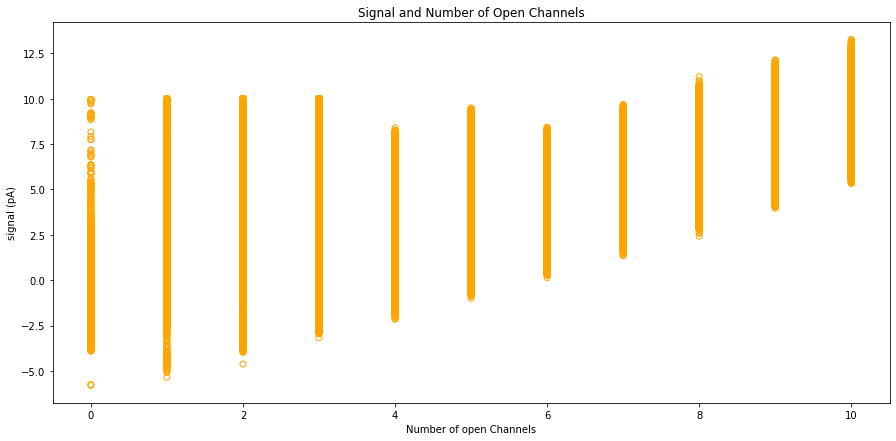

In [6]:
fig1, ax1 = plt.subplots(figsize=(15,7))

ax1.scatter(open_channels_train, signal_train, color='none', edgecolor='orange')
ax1.set(xlabel='Number of open Channels', ylabel='signal (pA)',
        title='Signal and Number of Open Channels')

From judging the graph above, there is a clear and distinct correlation with signal levels and the number orf open channels.  There appears to be a large range of signals when the number of channels is lower, when the number of channels get closer to 10, the range becomes smaller and more defined.

[Text(0, 0.5, 'Number of Open Channels'), Text(0.5, 0, 'Time')]

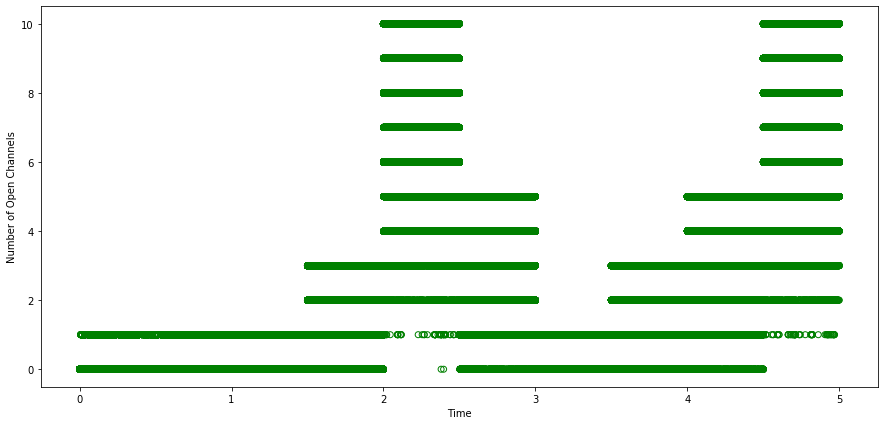

In [7]:
fig2, ax2 = plt.subplots(figsize=(15,7))
ax2.scatter(time_train, open_channels_train, color='none', edgecolor='green')
ax2.set(xlabel='Time', ylabel='Number of Open Channels')

[Text(0.5, 0, 'open channels'),
 Text(0.5, 0, 'signal (pA)'),
 Text(0.5, 0, 'time (s)')]

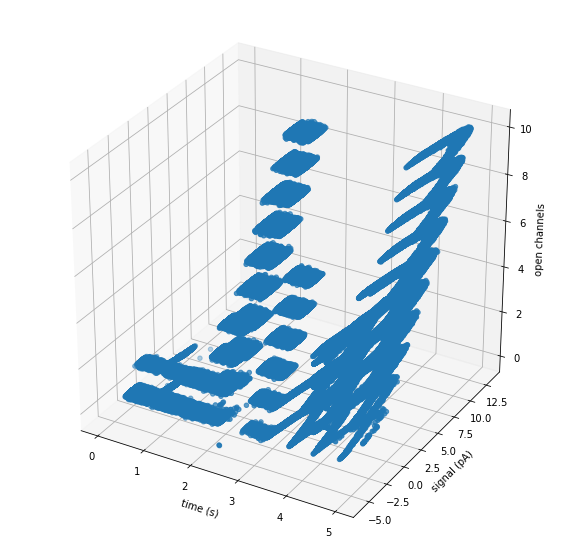

In [8]:
fig3 = plt.figure(figsize=(10,10))
ax3 = plt.axes(projection="3d")

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
open_channels_train = train_df.open_channels

x = time_train
y = signal_train
z = open_channels_train

ax3.scatter(x, y, z)
ax3.set(xlabel='time (s)', ylabel='signal (pA)', zlabel='open channels')

This does not help

In [9]:
train_df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


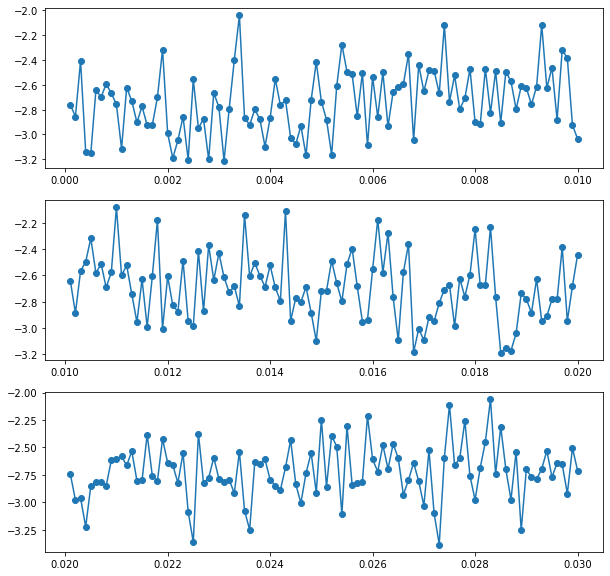

In [10]:
x_1 = train_df.time[0:100]
y_1 = train_df.signal[0:100]

x_2 = train_df.time[100:200]
y_2 = train_df.signal[100:200]

x_3 = train_df.time[200:300]
y_3 = train_df.signal[200:300]

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
(ax1, ax2, ax3) = axs

ax1.plot(x_1, y_1, '-o')
ax2.plot(x_2, y_2, '-o')
ax3.plot(x_3, y_3, '-o')


Having a closer look at the data, there is a lot of noise so we need to remove the noise with wavelet denoising

In [11]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')


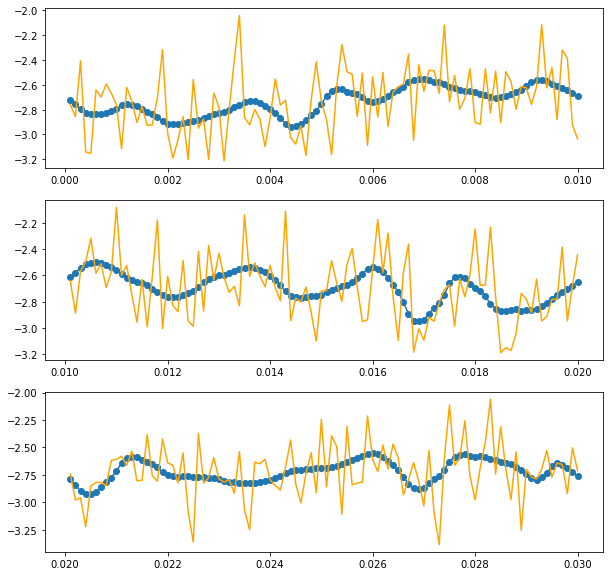

In [12]:
x_1 = train_df.time[0:100]
x_2 = train_df.time[100:200]
x_3 = train_df.time[200:300]

y_1 = train_df.signal[0:100]
y_2 = train_df.signal[100:200]
y_3 = train_df.signal[200:300]

y_1_transformed = denoise_signal(train_df.signal[0:100])

y_2_transformed = denoise_signal(train_df.signal[100:200])

y_3_transformed = denoise_signal(train_df.signal[200:300])

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10,10))
(ax1, ax2, ax3) = axs

ax1.plot(x_1, y_1_transformed, '-o')
ax2.plot(x_2, y_2_transformed, '-o')
ax3.plot(x_3, y_3_transformed, '-o')

ax1.plot(x_1, y_1, color='orange')
ax2.plot(x_2, y_2, color='orange')
ax3.plot(x_3, y_3, color='orange')


[Text(0, 0.5, 'signal (pA)'),
 Text(0.5, 0, 'time (s)'),
 Text(0.5, 1.0, 'Signal(pA) over time(s)')]

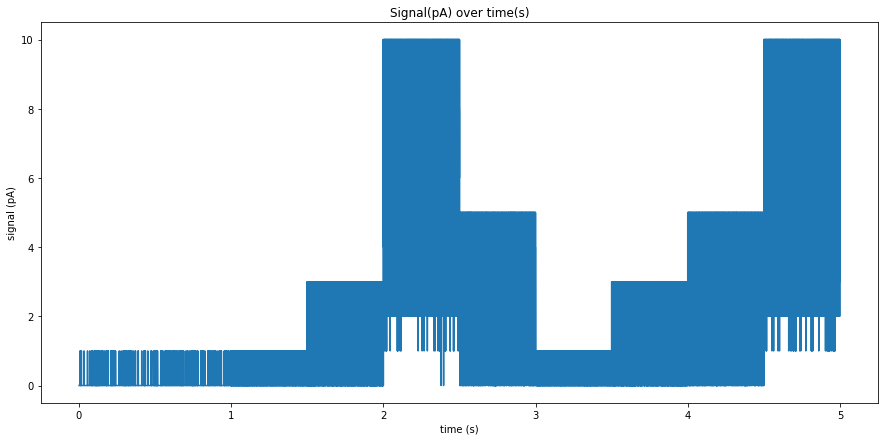

In [13]:
fig0, ax0 = plt.subplots(figsize=(15,7))

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
signal_train_denoised = denoise_signal(train_df.signal)

open_channels_train = train_df.open_channels

# ax0.plot(time_train, signal_train,'-o');
# ax0.plot(time_train, signal_train_denoised,'-o');
ax0.plot(time_train, open_channels_train)

ax0.set(xlabel='time (s)', ylabel='signal (pA)',
        title='Signal(pA) over time(s)')

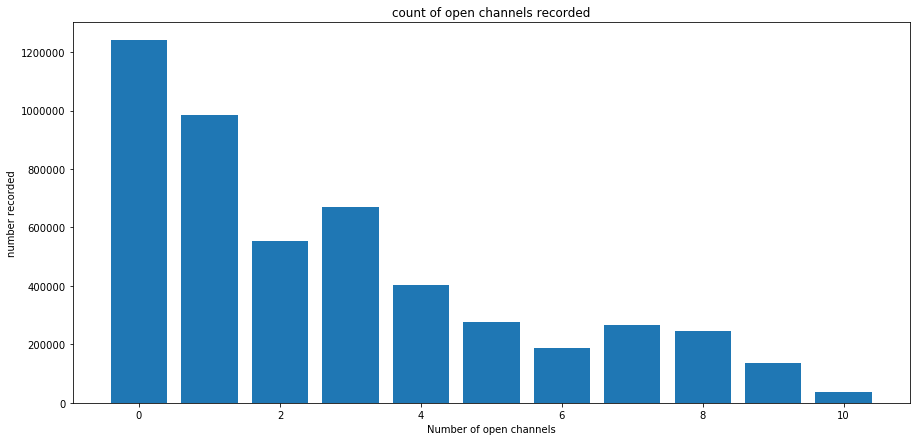

In [14]:
fig2, ax2 = plt.subplots(figsize=(15,7))
ax2.bar(x=list(range(11)), height=open_channels_train.value_counts(sort=False).values)
ax2.set(xlabel='Number of open channels', ylabel='number recorded',
        title='count of open channels recorded');

In [15]:
open_channel_0 = train_df.loc[train_df['open_channels']==0]
open_channel_1 = train_df.loc[train_df['open_channels']==1]
open_channel_2 = train_df.loc[train_df['open_channels']==2]
open_channel_3 = train_df.loc[train_df['open_channels']==3]
open_channel_4 = train_df.loc[train_df['open_channels']==4]
open_channel_5 = train_df.loc[train_df['open_channels']==5]
open_channel_6 = train_df.loc[train_df['open_channels']==6]
open_channel_7 = train_df.loc[train_df['open_channels']==7]
open_channel_8 = train_df.loc[train_df['open_channels']==8]
open_channel_9 = train_df.loc[train_df['open_channels']==9]
open_channel_10 = train_df.loc[train_df['open_channels']==10]

In [16]:
open_channel_avg_signal_list = [np.mean(denoise_signal(globals()[f'open_channel_{i}'].signal)) for i in range(11)]
open_channel_avg_signal_list

[-2.2617531376514575,
 0.04517022326096928,
 1.3180792522856881,
 2.527445059372603,
 3.572784175635032,
 4.1291211994927615,
 3.539647337213295,
 4.761488872608758,
 5.9984444158434425,
 7.2147441241960735,
 8.465608551983939]

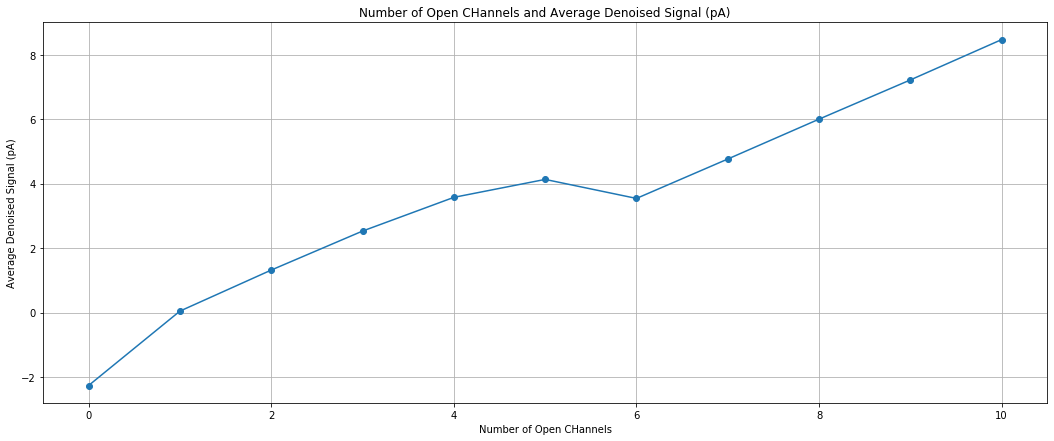

In [17]:
fig0, ax0 = plt.subplots(figsize=(18,7))
ax0.plot(list(range(11)),open_channel_avg_signal_list,'-o')
ax0.grid()
ax0.set(xlabel='Number of Open CHannels', ylabel='Average Denoised Signal (pA)',
        title='Number of Open CHannels and Average Denoised Signal (pA)');

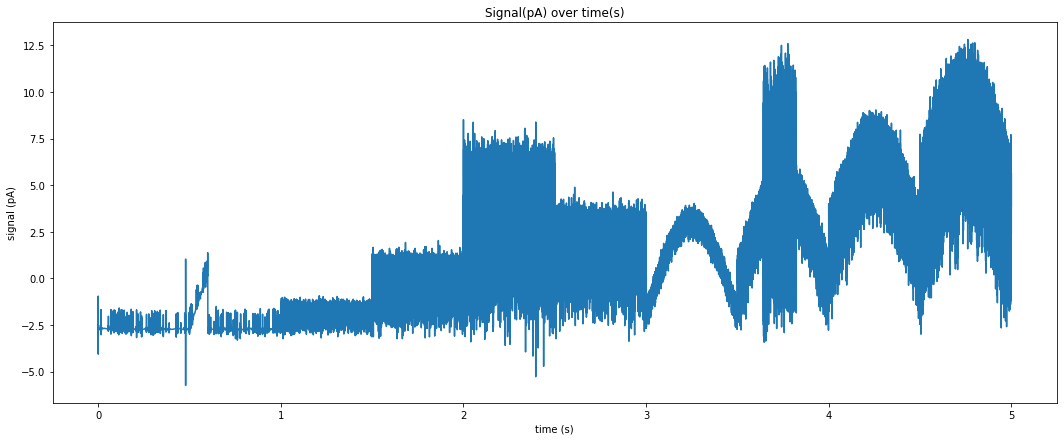

In [18]:
fig0, ax0 = plt.subplots(figsize=(18,7))

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
signal_train_denoised = denoise_signal(train_df.signal)

open_channels_train = train_df.open_channels
ax0.plot(time_train, signal_train_denoised);
ax0.set(xlabel='time (s)', ylabel='signal (pA)',
        title='Signal(pA) over time(s)');

In [ ]:
fig0, ax0 = plt.subplots(figsize=(18,7))

time_train = (train_df.time)/100 # this is for readability
signal_train = train_df.signal
signal_train_denoised = denoise_signal(train_df.signal)

open_channels_train = train_df.open_channels
ax0.bar(x=open_channels_train, height=signal_train_denoised);
ax0.set(xlabel='time (s)', ylabel='signal (pA)',
        title='Signal(pA) over time(s)');